# Checkbox/Table cell detection using OpenCV-Python

Jupyter Notebook based on the Article:

https://sreekiranar.medium.com/checkbox-table-cell-detection-using-opencv-python-332c57d25171


### importing necessary libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

Creating two flags; `plot_flag`: To activate plotting the output, `save_output`: To save the output to disk

In [2]:
image_path='digital.jpg'
plot_flag=True
save_output=True
out_folder='outs'
os.makedirs(out_folder,exist_ok=True)

In [3]:
image=cv2.imread(image_path)

### let's create a function to plot the image to avoid rewriting the code again and again

In [4]:
def plot(image,cmap=None):
    plt.figure(figsize=(15,15))
    plt.imshow(image,cmap=cmap) 

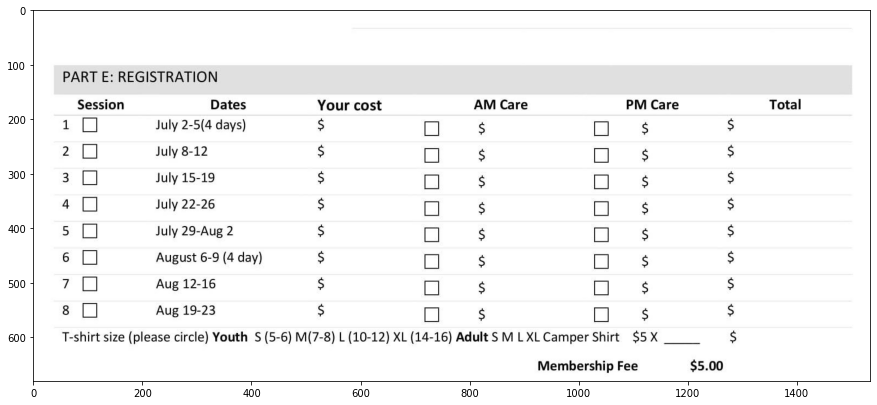

In [5]:
if plot_flag:
    plot(image)

### binarising the image and inversing 

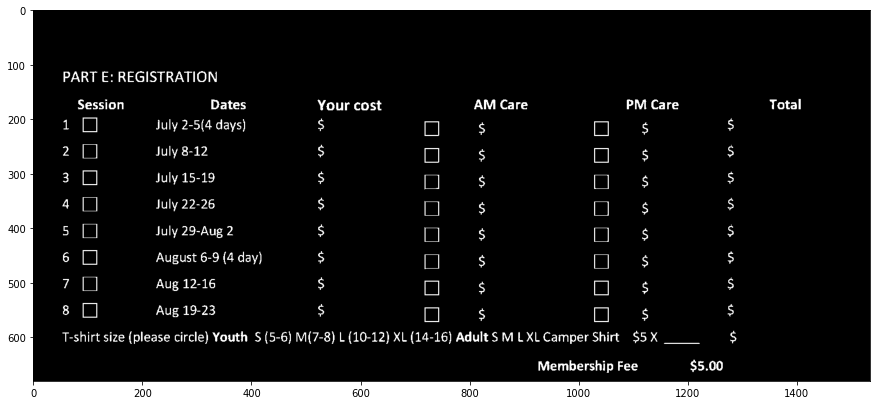

In [6]:
gray_scale=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
th1,img_bin = cv2.threshold(gray_scale,150,225,cv2.THRESH_BINARY)
img_bin=~img_bin
if plot_flag:
    plot(img_bin,'gray')
if save_output:
    cv2.imwrite(os.path.join(out_folder,f'bin_{image_path}'),img_bin)

### assuming the minimum checkbox size would be atleast 15x15

In [7]:
line_min_width = 15

### defining vertical and horizontal kernals for morphological operations

In [8]:
kernal_h = np.ones((1,line_min_width), np.uint8)
kernal_v = np.ones((line_min_width,1), np.uint8)

### Detecting Horizontal lines by applying Horizontal Kernal

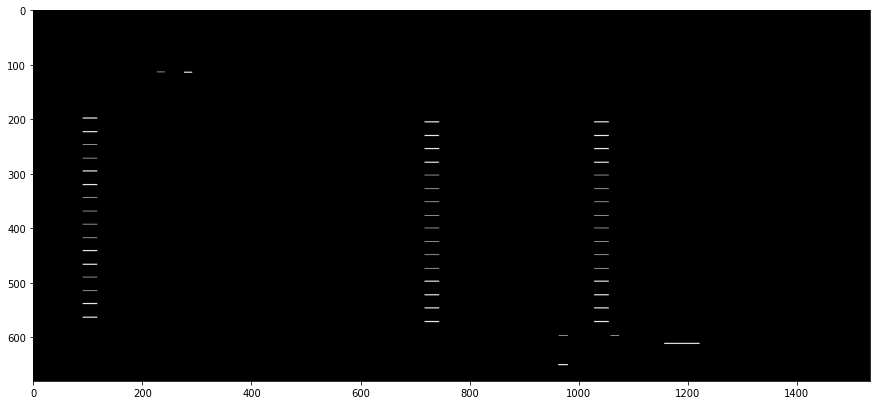

In [9]:
img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
if plot_flag:
    plot(img_bin_h,'gray')
if save_output:
    cv2.imwrite(os.path.join(out_folder,f'hor_{image_path}'),img_bin_h)

### Detecting Vertical lines by applying vertical Kernal

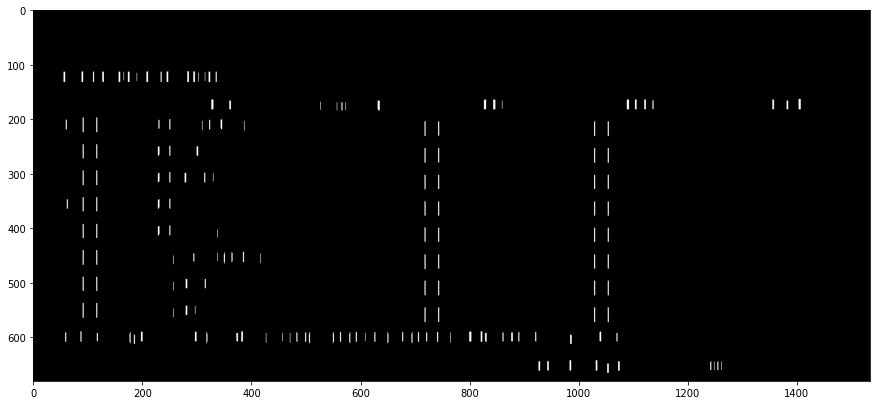

In [10]:
img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)
if plot_flag:
    plot(img_bin_v,'gray')
if save_output:
    cv2.imwrite(os.path.join(out_folder,f'ver_{image_path}'),img_bin_v)

### Merging horizontal and vertical lines

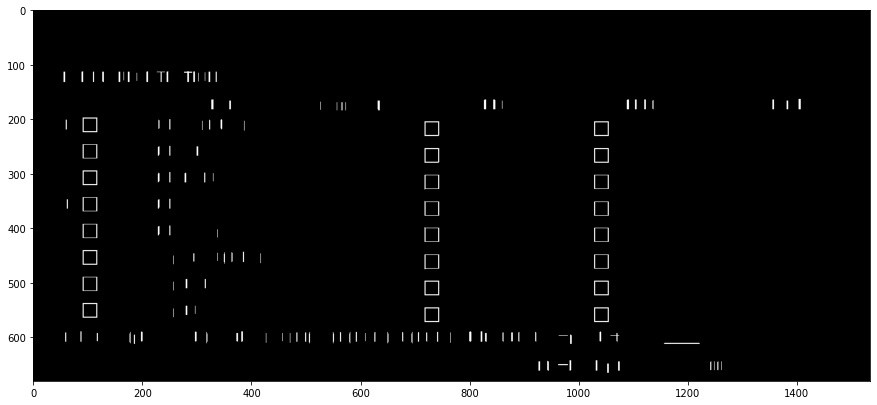

In [11]:
img_bin_final=img_bin_h|img_bin_v
if plot_flag:
    plot(img_bin_final,'gray')
if save_output:
    cv2.imwrite(os.path.join(out_folder,f'merge_{image_path}'),img_bin_final)

### Adding a Layer of dilation to close small gaps

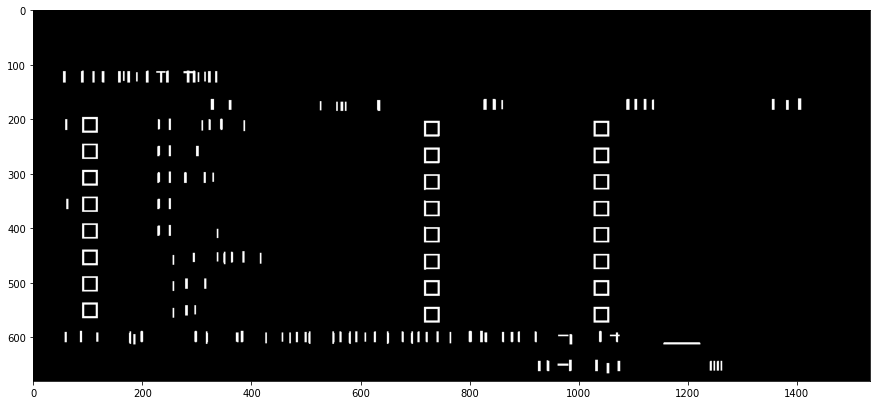

In [12]:
final_kernel = np.ones((3,3), np.uint8)
img_bin_final=cv2.dilate(img_bin_final,final_kernel,iterations=1)
if plot_flag:
    plot(img_bin_final,'gray')
if save_output:
    cv2.imwrite(os.path.join(out_folder,f'final_bin_{image_path}'),img_bin_final)

### Inverting the image and finding the connected components

In [13]:
ret, labels, stats,centroids = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)

What is Connected component Analyis?
You can check this stackOverflow answer for understanding the basic logic, I am planning to write an article about connected component analysis and how we can leverage them in solving segmentation/detection challenges with the help of image morphological operations

In [14]:
### lets visualise the connected component image using the function

def imshow_components(labels):
    ### creating a hsv image, with a unique hue value for each label
    label_hue = np.uint8(179*labels/np.max(labels))
    ### making saturation and volume to be 255
    empty_channel = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, empty_channel, empty_channel])
    ### converting the hsv image to BGR image
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue==0] = 0
    ### returning the color image for visualising Connected Componenets
    return labeled_img

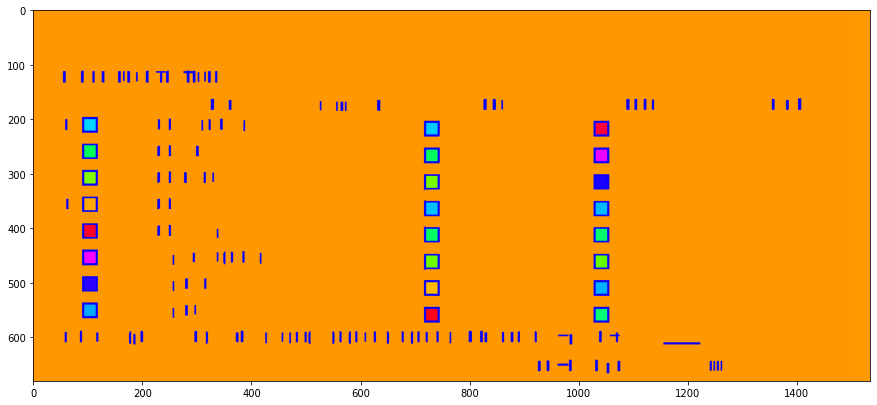

In [15]:
out_image=imshow_components(~labels)
if plot_flag:
    plot(out_image)
if save_output:
    cv2.imwrite(os.path.join(out_folder,f'cc_{image_path}'),out_image)

You can see all the checkboxes have been detected and assigned with a color

Now let's loop through each checkbox and draw a bounding box on them

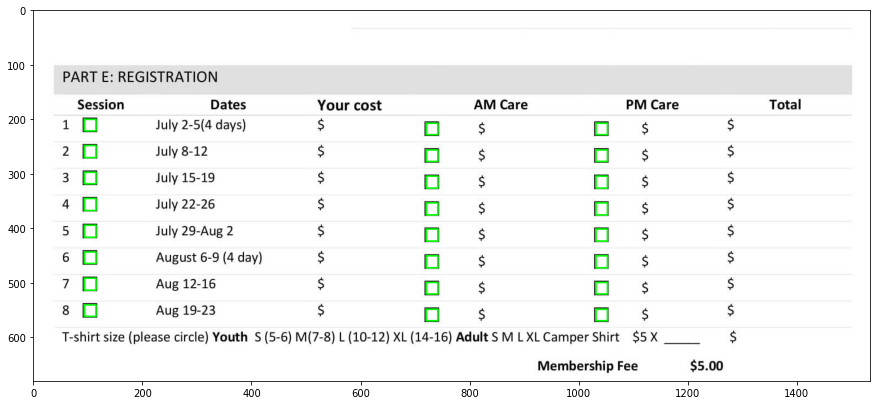

In [16]:
### skipping the first 2 labels, why? 
### 1 and 0 and the background and residue connected components whihc we do not require
for x,y,w,h,area in stats[2:]:
#     cv2.putText(image,'box',(x-10,y-10),cv2.FONT_HERSHEY_SIMPLEX, 1.0,(0,255,0), 2)
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
if plot_flag:
    plot(image)
if save_output:
    cv2.imwrite(os.path.join(out_folder,f'output_{image_path}'),image)

In [17]:
def detect_box(image,line_min_width=15):
    gray_scale=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    th1,img_bin = cv2.threshold(gray_scale,150,225,cv2.THRESH_BINARY)
    kernal6h = np.ones((1,line_min_width), np.uint8)
    kernal6v = np.ones((line_min_width,1), np.uint8)
    img_bin_h = cv2.morphologyEx(~img_bin, cv2.MORPH_OPEN, kernal6h)
    img_bin_v = cv2.morphologyEx(~img_bin, cv2.MORPH_OPEN, kernal6v)
    img_bin_final=img_bin_h|img_bin_v
    final_kernel = np.ones((3,3), np.uint8)
    img_bin_final=cv2.dilate(img_bin_final,final_kernel,iterations=1)
    ret, labels, stats,centroids = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)
    return stats,labels

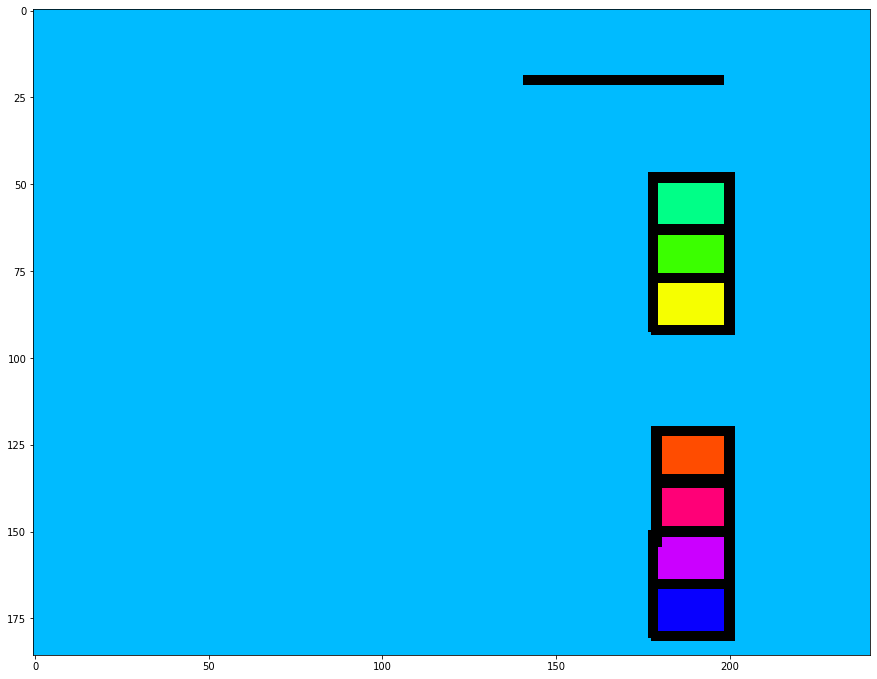

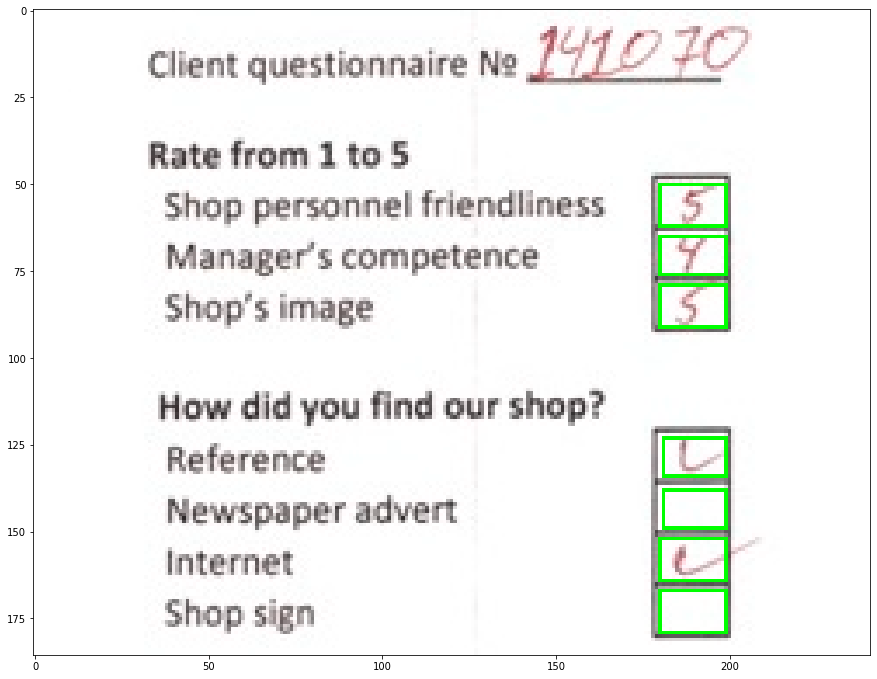

In [19]:
image_path='scanned.jpg'
image=cv2.imread(image_path)
stats,labels=detect_box(image)
cc_out=imshow_components(labels)

for x,y,w,h,area in stats[2:]:
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),1)

if plot_flag:
    plot(cc_out)
    plot(image) 
if save_output:
    cv2.imwrite(os.path.join(out_folder,f'cc_{image_path}'),cc_out)
    cv2.imwrite(os.path.join(out_folder,f'out_{image_path}'),image)

What is a table cell? Is'nt that a larger version of checkbox itself. Let's Run our current algorithm on a low quality scanned table and see the results

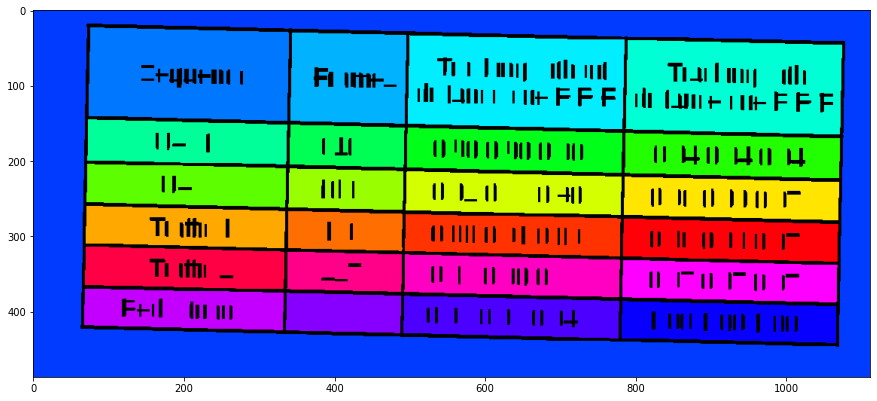

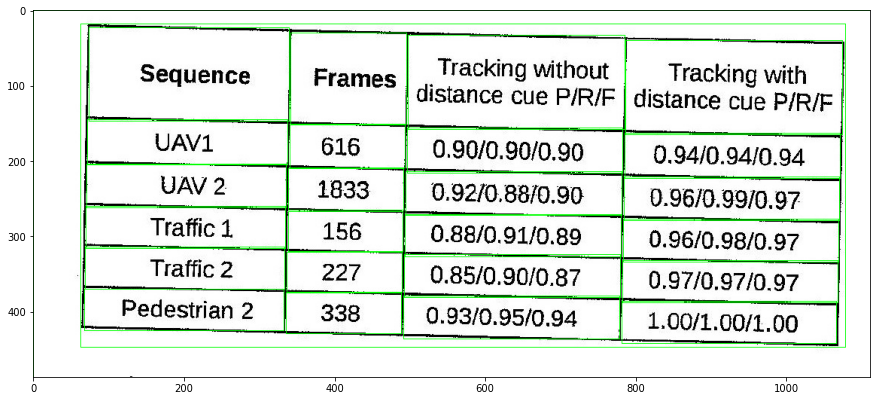

In [20]:
image_path='scanned_table.jpg'
image=cv2.imread(image_path)
stats,labels=detect_box(image)
cc_out=imshow_components(labels)

for x,y,w,h,area in stats:
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),1)

if plot_flag:
    plot(cc_out)
    plot(image) 
if save_output:
    cv2.imwrite(os.path.join(out_folder,f'cc_{image_path}'),cc_out)
    cv2.imwrite(os.path.join(out_folder,f'out_{image_path}'),image)

Notice that here I'm not skipping any stats we detected. So, I'm getting the entire image as a bounding box, and also the full table itself as a bounding box.

**Author**: Sreekiran A R

**LinkedIn**: https://www.linkedin.com/in/sreekiranar/

**StackOverflow**: https://stackoverflow.com/users/9605907/sreekiran

**GitHub**: https://github.com/Sreekiranar

**Medium**: https://medium.com/@sreekiranar

**HackerRank**: https://www.hackerrank.com/Sreekiran